<a href="https://colab.research.google.com/github/nicolastibata/MINE_4210_ADL_202520/blob/main/labs/Laboratorio_7/MINE__4210_ADL_202520_L7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/nicolastibata/MINE_4210_ADL_202520/blob/main/docs/images/logo.png?raw=true)


# **Laboratorio 7: Redes RNN + Embeddings**
**Tutor: Nicolás Tibatá**

## **Tabla de Contenido**

[Contexto y objetivos](#scrollTo=5KnQpgpopi8a)<br>
[1. Introducción de los datos](#scrollTo=VjA8zwzJvmeO)<br>
[2. Preparación y Modelamiento](#scrollTo=kG8XHROzvuEH)<br>
[3. Taller 3](#scrollTo=JTKc52_Wvs_N)<br>

### **Contexto y Objetivos**

Se requiere realizar el análisis de sentimientos de un conjunto de tweets relacionadas al uso de inteligencia artificial. Con el objetivo de conocer la opinión general y las posibles decisiones a futuro.

### **Objetivos**

1. Analizar la construcción de una Red Neuronal Recurrente.
2. Entrenar una red recurrente LSTM para resolver un problema de análisis de sentimientos.


**Datos:** [tweet-gpt](https://www.kaggle.com/datasets/evilspirit05/tweet-gpt)

### **1. Introducción a los datos**

In [1]:
# Instalación e Importación de librerías
!pip install keras-tuner -q
!pip install contractions -q
!pip install num2words -q

import os
import shutil
from PIL import Image

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import num2words
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

import contractions
import unicodedata
import re

import tensorflow as tf
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TextVectorization, Embedding, SpatialDropout1D

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from google.colab import files
from google.colab import userdata

print('Tensorflow version:', tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 12.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Tensorflow version: 2.19.0


In [2]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d evilspirit05/tweet-gpt
!unzip "tweet-gpt.zip"


Dataset URL: https://www.kaggle.com/datasets/evilspirit05/tweet-gpt
License(s): MIT
  0% 0.00/9.54M [00:00<?, ?B/s]
100% 9.54M/9.54M [00:00<00:00, 1.08GB/s]
Archive:  tweet-gpt.zip
  inflating: tweet_gpt.csv           


In [3]:
data = pd.read_csv('/content/tweet_gpt.csv')
data.head(5)

,Date,Tweet,Url,User,UserCreated,UserVerified,UserFollowers,UserFriends,Retweets,Likes,...,New_Date,Time,Hour,Day,TweetStr,hashtags,clean_tweet,sentiment_label,sentiment_score,sentiment
0,2023-04-08 03:31:08+00:00,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,https://twitter.com/tubeblogger/status/1644543...,tubeblogger,2013-06-25 01:42:59+00:00,False,312.0,293.0,0.0,0,...,2023-04-08,03:31:08,3,Saturday,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,"['ai', 'ChatGPT']",openai’s gpt4 just got supercharged!,-,0.917779,positive
1,2023-04-08 03:30:51+00:00,"""Classical art"" is struggling - not changed th...",https://twitter.com/majorradic/status/16445432...,majorradic,2011-12-12 01:29:15+00:00,False,522.0,684.0,0.0,2,...,2023-04-08,03:30:51,3,Saturday,"""Classical art"" is struggling - not changed th...","['ChatGPT', 'chatgpt3', 'AIArtwork', 'AI', 'AI...","classical art"" is struggling not changed the ...",-,0.515711,neutral
2,2023-04-08 03:30:00+00:00,Alibaba invites businesses to trial 'ChatGPT r...,https://twitter.com/gadgetsnow/status/16445430...,gadgetsnow,2010-07-29 10:32:28+00:00,True,90392.0,56.0,0.0,0,...,2023-04-08,03:30:00,3,Saturday,Alibaba invites businesses to trial 'ChatGPT r...,"['Alibaba', 'ChatGPT']",alibaba invites businesses to trial chatgpt ri...,-,0.924410,neutral
3,2023-04-08 03:28:59+00:00,Trying to stop students from using #AI and #ch...,https://twitter.com/Sherab_Taye/status/1644542...,Sherab_Taye,2010-05-10 12:40:40+00:00,False,338.0,53.0,0.0,0,...,2023-04-08,03:28:59,3,Saturday,Trying to stop students from using #AI and #ch...,"['AI', 'chatGPT']",trying to stop students from using and is like...,-,0.636237,negative
4,2023-04-08 03:28:31+00:00,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,https://twitter.com/cryptoccentral/status/1644...,cryptoccentral,2023-01-27 00:12:12+00:00,False,1.0,2.0,0.0,2,...,2023-04-08,03:28:31,3,Saturday,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,"['crypto', 'bitcoin', 'cryptocurrency', 'ai', ...",i asked chatgpts ai chatbot how can i earn cry...,-,0.916693,neutral


In [4]:
# Mantenemos el texto y el sentimiento unicamente
data = data[['Tweet', 'sentiment']]
data.head(5)

,Tweet,sentiment
0,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,positive
1,"""Classical art"" is struggling - not changed th...",neutral
2,Alibaba invites businesses to trial 'ChatGPT r...,neutral
3,Trying to stop students from using #AI and #ch...,negative
4,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,neutral


In [5]:
unique_sentiments = data['sentiment'].unique()

for sentiment in unique_sentiments:
    row = data[data['sentiment'] == sentiment].iloc[0]  # Obtener la primera fila con el valor de sentimiento específico
    print("Sentiment:", sentiment)
    print("Sentence:", row['Tweet'])
    print()


Sentiment: positive
Sentence: OpenAI’s GPT-4 Just Got Supercharged! #ai #ChatGPT  https://t.co/RgMkZlYuRn

Sentiment: neutral
Sentence: "Classical art" is struggling - not changed the fact that is disappearing.

ARTofficial:
It is important that 1/100 passes.
Thousands and thousands will be made.

#ChatGPT #chatgpt3
#AIArtwork #AI #AIPAD
#NFT #Web3 #chatgpt4 #nftarti̇st #AIart #nftart
#NFTJapan #Bing #BingAI

Sentiment: negative
Sentence: Trying to stop students from using #AI and #chatGPT is like trying to stop them from using internet in the early 90s.



In [6]:
data["sentiment"].value_counts()

,count
sentiment,
neutral,19218
positive,11705
negative,6537


### **2. Preparación y Modelamiento**

#### **Preparación**

El objetivo del preprocesamiento es limpiar y estandarizar el texto para que sea más adecuado para su uso.

In [7]:
def remove_stopwords(words):
  for word in STOPWORDS:
    token = ' ' + word + ' '
    words = re.sub(token, ' ', words)
  return words

def preproccesing(words):
    #pasar el texto a minúsculas
    words = words.lower()
    #pasar números a palabras
    #words = re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), words)
    #remove_punctuation se omite el caracter - dado que en inglés se usa en palabras compuestas.
    words = re.sub(r"([\"(),¡!¿?:;'></]|\\s)+", "", words)
    #Remove non-ASCII characters
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #Remove Stopwords
    words = remove_stopwords(words)
    #Stem and lemma
    #words = stem_and_lemmatize(words)
    return words

In [8]:
data["Tweet"] = data["Tweet"].apply(contractions.fix)
data["Tweet"] = data["Tweet"].apply(preproccesing)

In [9]:
data['Tweet'].head(5)

,Tweet
0,openais gpt-4 got supercharged #ai #chatgpt h...
1,classical art struggling - changed fact disapp...
2,alibaba invites businesses trial chatgpt rival...
3,trying stop students using #ai #chatgpt like t...
4,i asked chatgpts ai chatbot earn crypto | trad...


Ahora vamos a pasar el sentimiento (clase) a un valor entero usando LabelEncoder

In [10]:
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])

etiquetas_unicas = label_encoder.classes_
for valor_numerico, etiqueta_original in enumerate(etiquetas_unicas):
    print(f'Valor numérico: {valor_numerico}, Etiqueta original: {etiqueta_original}')

Valor numérico: 0, Etiqueta original: negative
Valor numérico: 1, Etiqueta original: neutral
Valor numérico: 2, Etiqueta original: positive


In [11]:
# Divide los datos en entrenamiento y prueba
train, test = train_test_split(data, test_size=0.2, stratify=data['sentiment'], random_state=42, shuffle = True)

# Ahora divide el conjunto de entrenamiento en entrenamiento y validación
train, val = train_test_split(train, test_size=0.2, stratify=train['sentiment'], random_state=42, shuffle = True)

print("Tamaño de datos de entrenamiento:", train.shape)
print("Tamaño de datos de validación:", val.shape)
print("Tamaño de datos de prueba:", test.shape)

train

Tamaño de datos de entrenamiento: (23974, 2)
Tamaño de datos de validación: (5994, 2)
Tamaño de datos de prueba: (7492, 2)


,Tweet,sentiment
8010,every generation mistakenly thinks last. seein...,0
30863,introducing innovative #room22 project owning ...,2
21970,italy bans #chatgpt - interesting move\nhttpst...,2
15743,here another learning angle time #chatgpt admi...,0
8006,wow week never felt safer @gpdp_it blocked #ch...,2
...,...,...
32711,the basic truth behind #chatgpt &amp #chatgpt4...,0
23463,httpst.cokju103bpja\nthat going interesting. ...,2
34292,indian version chatgpt announced soon says min...,1
3502,and still dare offer paid service fuck wrong #...,0


Separamos las oraciones y el sentimiento que representan.


In [12]:
X_train, X_test, X_val= train['Tweet'], test['Tweet'], val['Tweet']
y_train, y_test, y_val= train['sentiment'], test['sentiment'], val['sentiment']

print("x_train", X_train.shape, " y_train:", y_train.shape)
print("x_test:", X_test.shape, "y_test", y_test.shape)
print("x_val", X_val.shape, "y_val:", y_val.shape)

x_train (23974,)  y_train: (23974,)
x_test: (7492,) y_test (7492,)
x_val (5994,) y_val: (5994,)


Revisamos la dristibución de sentimientos del conjunto de entrenamiento:

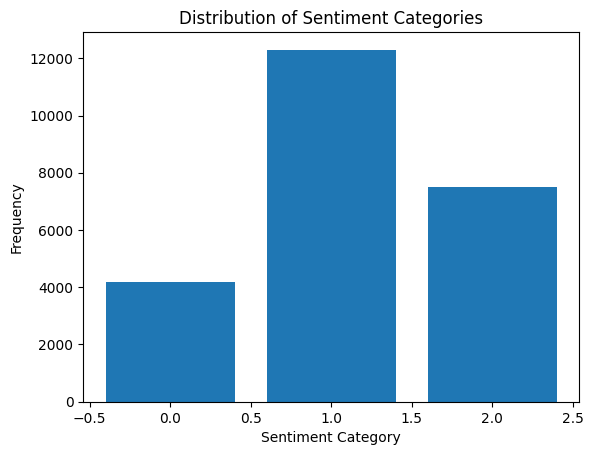

In [13]:
# Create a bar plot to visualize the distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Categories')
plt.show()

#### **Modelamiento**

Vamos a pasar los datos de texto a un tensor:

In [14]:
X_train_tf = tf.convert_to_tensor(X_train)
X_val_tf = tf.convert_to_tensor(X_val)
X_test_tf = tf.convert_to_tensor(X_test)

X_train_tf

<tf.Tensor: shape=(23974,), dtype=string, numpy=
array([b'every generation mistakenly thinks last. seeing happen chatgpt. #artificialintelligence #openai #ai #chatgpt httpst.cokna5xkddy1',
       b'introducing innovative #room22 project owning #nft means owning piece music earning royalties miss chance part revolutionary concept. check @rocstar22_ \n#chatgpt wrote ',
       b'italy bans #chatgpt - interesting move\nhttpst.co2yngdpykyk',
       ...,
       b'indian version chatgpt announced soon says minister\n@techshotsapp\n\n#chatgpt #indian #it\n\nhttpst.conweel7rvsy',
       b'and still dare offer paid service fuck wrong #chatgpt whole week without access. httpst.cooftnnbff2k',
       b'question everyone.\n\nwill #chatgpt able tell future\n\nif when'],
      dtype=object)>

Ahora hacemos la definición de la capa Vectorize, que se utiliza para tokenización de los textos, y será el punto de entrada de nuestra red neuronal.

[***tf.keras.layers.TextVectorization***](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) es una capa de preprocesamiento que convierte características de texto en secuencias de enteros. Esta capa es útil para preparar datos de texto para su uso en modelos de aprendizaje automático.

El preprocesamiento contiene los siguientes pasos:

*   Normalizar cada ejemplo (normalmente minúsculas + eliminación de puntuación)
*   Dividir cada ejemplo en subcadenas (normalmente palabras).
*   Recombinar las subcadenas en tokens (normalmente ngramas)
*   Indexar los tokens (asociar un valor int único a cada token)
*   Transformar cada ejemplo utilizando este índice, ya sea en un vector de ints o en un vector denso de floats.

In [15]:
#Capa para tokenización
vectorize_layer = TextVectorization(
    standardize=None,
    split = "whitespace",
    max_tokens=None,
    output_mode='int',
    output_sequence_length=None)

# El método adapt permite construir el vocabulario.
vectorize_layer.adapt(X_train_tf)

In [20]:
# Tokenizar tus datos
X_train_tk = vectorize_layer(X_train)
X_val_tk = vectorize_layer(X_val)
X_test_tk = vectorize_layer(X_test)

#row_index = 2
print("Texto original en X_train:", X_train[1], end="\n")
print("Texto tokenizado en X_train_tk:", X_train_tk[1])


Texto original en X_train: classical art struggling - changed fact disappearing.

artofficial
it important 1100 passes.
thousands thousands made.

#chatgpt #chatgpt3
#aiartwork #ai #aipad
#nft #web3 #chatgpt4 #nftartist #aiart #nftart
#nftjapan #bing #bingai
Texto tokenizado en X_train_tk: tf.Tensor(
[  827  1059 65027   432  7984   105   857  7984   920   909  4841 24490
   434   938   359  2101  9888    38 57597     2   491     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(65,), dtype=int64)


Veamos como queda la representación del vocabulario del conjunto X_train

In [21]:
print("Vocabulario:", vectorize_layer.get_vocabulary())
print("Configuración:", vectorize_layer.get_config())

Vocabulario: ['', '[UNK]', np.str_('#chatgpt'), np.str_('#ai'), np.str_('ai'), np.str_('chatgpt'), np.str_('#openai'), np.str_('-'), np.str_('#artificialintelligence'), np.str_('like'), np.str_('&amp'), np.str_('i'), np.str_('use'), np.str_('#gpt4'), np.str_('new'), np.str_('using'), np.str_('the'), np.str_('us'), np.str_('data'), np.str_('get'), np.str_('business'), np.str_('#generativeai'), np.str_('could'), np.str_('help'), np.str_('technology'), np.str_('make'), np.str_('via'), np.str_('asked'), np.str_('one'), np.str_('read'), np.str_('#technology'), np.str_('know'), np.str_('language'), np.str_('chat'), np.str_('would'), np.str_('time'), np.str_('future'), np.str_('#chatgpt4'), np.str_('check'), np.str_('think'), np.str_('@openai'), np.str_('#midjourney'), np.str_('learn'), np.str_('better'), np.str_('world'), np.str_('take'), np.str_('#machinelearning'), np.str_('tools'), np.str_('write'), np.str_('see'), np.str_('course'), np.str_('gpt'), np.str_('italy'), np.str_('people'), np

Analizamos y visualizamos la longitud de las secuencias de texto en el conjunto de entrenamiento X_train

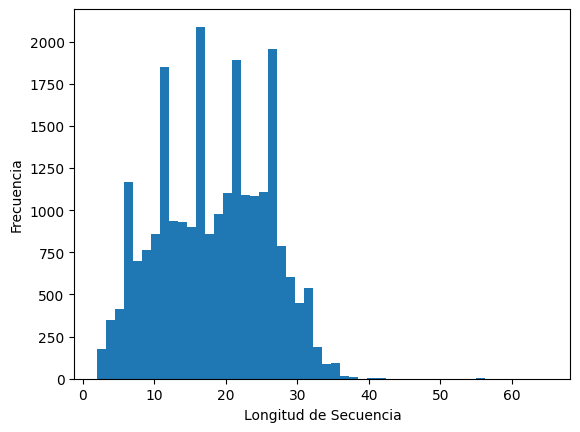

In [22]:
sequence_lengths = [len(text.split()) for text in X_train]
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Longitud de Secuencia')
plt.ylabel('Frecuencia')
plt.show()

In [23]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    # tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
]

Definiremos la arquitectura de nuestra Red Neuronal Base. Dado que es un problema multiclase se usa ***sparse_categorical_crossentropy*** como función de pérdida y se establecen 3 neuronas en la capa de salida.

Para la entrada usaremos la capa **vectorize_layer** (definida anteriormente), seguido de una capa de **Embedding** que es una de las capas fundamentales en el procesamiento de lenguaje natural (NLP) en modelos de redes neuronales. Su función principal es convertir palabras o tokens en representaciones numéricas, lo que permite que los modelos de aprendizaje automático trabajen con texto.

También usaremos la capa **SpatialDropout1D** es una técnica de regularización que desactiva secuencias completas en lugar de nodos individuales y puede ser útil en modelos de procesamiento de lenguaje natural para prevenir el sobreajuste y mejorar la generalización del modelo.

La capa **LSTM** (Long Short-Term Memory) es una capa especializada en redes neuronales recurrentes (RNN) y secuencias temporales debido a su capacidad para manejar secuencias largas y capturar dependencias a largo plazo.

In [24]:
model = Sequential()

model.add(vectorize_layer)
model.add(Embedding(10000, 300, name="Capa_Embedding"))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1024, activation='relu', name='Capa_Oculta'))
model.add(Dropout(0.8))
model.add(Dense(3, activation='softmax', name='Capa_Salida'))  # 3 para 3 clases

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [25]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
with tf.device('/device:GPU:0'):
  model.fit(
      X_train_tf, y_train,
      validation_data = (X_val_tf, y_val),
      epochs=20,
      callbacks=my_callbacks)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 98s 119ms/step - accuracy: 0.5740 - loss: 0.9587 - val_accuracy: 0.6650 - val_loss: 0.7995
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 88s 118ms/step - accuracy: 0.7098 - loss: 0.7319 - val_accuracy: 0.6737 - val_loss: 0.7467
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 90s 119ms/step - accuracy: 0.7502 - loss: 0.5970 - val_accuracy: 0.7127 - val_loss: 0.6899
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 88s 117ms/step - accuracy: 0.8366 - loss: 0.4247 - val_accuracy: 0.7314 - val_loss: 0.7177
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 88s 117ms/step - accuracy: 0.8861 - loss: 0.3097 - val_accuracy: 0.7144 - val_loss: 0.7524
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 88s 117ms/step - accuracy: 0.9119 - loss: 0.2475 - val_accuracy: 0.7149 - val_loss: 0.8343
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 87s 116ms/step - accuracy: 0.9278 - loss: 0.2024 - val_accuracy: 0.7089 - val_loss: 1.0889


Evaluemos el modelo

In [27]:
y_pred = model.predict(X_train_tf)
y_pred = np.argmax(y_pred, axis=1)
y_pred

750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step


array([0, 2, 2, ..., 1, 0, 1])

In [28]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4184
           1       0.96      0.96      0.96     12299
           2       0.98      0.95      0.97      7491

    accuracy                           0.96     23974
   macro avg       0.95      0.96      0.95     23974
weighted avg       0.96      0.96      0.96     23974



In [29]:
y_pred_test = model.predict(X_test_tf)
y_pred_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_test))

235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step
              precision    recall  f1-score   support

           0       0.58      0.62      0.60      1307
           1       0.74      0.77      0.76      3844
           2       0.76      0.69      0.72      2341

    accuracy                           0.72      7492
   macro avg       0.69      0.69      0.69      7492
weighted avg       0.72      0.72      0.72      7492



Este modelo básico presenta sobreajuste. Para mejorarlo, necesitamos realizar una búsqueda de hiperparámetros para lograr una mejor generalización del modelo como lo pueden ser:

Hiperparámetros de la capa LSTM
*   units
*   dropout y recurrent_dropout

Hiperparámetros de la capa de embedding
*   input_dim
*   output_dim

Hiperparámetros de capas de dropout:
*   rate

Tamaño del vocabulario y longitud de secuencia

Número de capas ocultas

Tamaño del batch y número de épocas


### **3. Taller 3**

-----

**Instrucciones**
1. El archivo a presentar debe ser en formato .ipynb o HTML con sus celdas ejecutadas. Celdas sin ejecutar no podrán ser evaluadas.
2. El nombre del archivo debe ser taller_3_{Apellido_Nombre}_{Apellido_Nombre} de cada integrante del equipo.
3. Las entregas solo se hacen a través de Bloque Neón.

-----

1. ¿Cuáles ajustes aplicaría para solucionar el problema del sobreajuste? Documente los cambios de manera de bulletpoints en una celda markdown y ejecute los cambios al modelo base.

2. Ahora cree un nuevo modelo con un embedding preentrenado [GloVe](https://nlp.stanford.edu/projects/glove/) (http://nlp.stanford.edu/data/glove.6B.zip). ¿Qué pasos adicionales debe implementar para acoplarlo al modelo base del punto 1?
> Por ejemplo la creación de la matriz de incrustración.

3. Genere una búsqueda de hiperparámetros para el modelo base del punto 1 y compárelo con los resultados del modelo del punto 2 en una tabla. ¿Cuáles son sus conclusiones?